In [2]:
from __future__ import print_function
from packaging.version import parse as Version
from platform import python_version

OK = '\x1b[42m[ OK ]\x1b[0m'
FAIL = "\x1b[41m[FAIL]\x1b[0m"

try:
    import importlib
except ImportError:
    print(FAIL, "Python version 3.10 is required,"
                " but %s is installed." % sys.version)

def import_version(pkg, min_ver, fail_msg=""):
    mod = None
    try:
        mod = importlib.import_module(pkg)
        if pkg in {'PIL'}:
            ver = mod.VERSION
        else:
            ver = mod.__version__
        if Version(ver) == Version(min_ver):
            print(OK, "%s version %s is installed."
                  % (lib, min_ver))
        else:
            print(FAIL, "%s version %s is required, but %s installed."
                  % (lib, min_ver, ver))    
    except ImportError:
        print(FAIL, '%s not installed. %s' % (pkg, fail_msg))
    return mod


# first check the python version
pyversion = Version(python_version())

if pyversion >= Version("3.10"):
    print(OK, "Python version is %s" % pyversion)
elif pyversion < Version("3.10"):
    print(FAIL, "Python version 3.10 is required,"
                " but %s is installed." % pyversion)
else:
    print(FAIL, "Unknown Python version: %s" % pyversion)

    
print()
requirements = {'numpy': "1.22.4", 'matplotlib': "3.5.2",'sklearn': "1.1.1", 
                'pandas': "1.4.2",'xgboost': "1.5.1", 'shap': "0.40.0"}

# now the dependencies
for lib, required_version in list(requirements.items()):
    import_version(lib, required_version)

[ OK ] Python version is 3.10.5

[ OK ] numpy version 1.22.4 is installed.
[ OK ] matplotlib version 3.5.2 is installed.
[ OK ] sklearn version 1.1.1 is installed.
[ OK ] pandas version 1.4.2 is installed.
[ OK ] xgboost version 1.5.1 is installed.
[ OK ] shap version 0.40.0 is installed.


In [3]:
# all imports
import pandas as pd
import numpy as np
import yfinance as yf 
import warnings
warnings.simplefilter("ignore", UserWarning)
import datetime

import matplotlib.pyplot as plt

from ta.momentum import AwesomeOscillatorIndicator, KAMAIndicator, \
    PercentagePriceOscillator, ROCIndicator, RSIIndicator, StochRSIIndicator, \
    StochasticOscillator, TSIIndicator

from ta.volume import AccDistIndexIndicator, ChaikinMoneyFlowIndicator, \
    EaseOfMovementIndicator, ForceIndexIndicator, MFIIndicator, \
     NegativeVolumeIndexIndicator, OnBalanceVolumeIndicator, \
        VolumePriceTrendIndicator, VolumeWeightedAveragePrice

from ta.volatility import AverageTrueRange, UlcerIndex

from ta.trend import ADXIndicator, AroonIndicator, CCIIndicator, DPOIndicator, \
    EMAIndicator, SMAIndicator, WMAIndicator

import matplotlib.dates as mdates
import matplotlib as mpl
import matplotlib.gridspec as gridspec

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder
from sklearn.model_selection import KFold, TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import recall_score, precision_score, f1_score, \
    confusion_matrix, ConfusionMatrixDisplay, make_scorer, accuracy_score
import shap

In [4]:
spy_ohlc_df = pd.read_excel("../data/S&P500 Data.xlsx")
spy_ohlc_df = spy_ohlc_df.drop(labels=["Unnamed: 0"], axis=1)
print(spy_ohlc_df.columns)

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Dates', 'AwesomeIndicator',
       'KAMA', 'PercentagePriceOscillator', 'ROC', 'RSI', 'StochRSI',
       'StochasticOscillator', 'TSI', 'AccDistIndicator', 'ChaikinMoneyFlow',
       'EaseOfMovement', 'ForceIndex', 'MFI', 'NegativeVolumeIndex',
       'OnBalanceVolume', 'VolumePriceTrend', 'VolumeWeightedAveragePrice',
       'Average True Range', 'Ulcer Index', 'ADX', 'Aroon', 'CCI', 'DPO',
       'EMA', 'SMA', 'WMA', 'Month', 'Prev Close Return 1 Day',
       'Prev Close Return 2 Days', 'Prev Close Return 3 Days',
       'Percent Next Day', 'Price Next Day'],
      dtype='object')


In [5]:
def optimize_algorithm(X, y, preprocessor, clf, param_grid, val_size=0.5, num_rand_states=10):
    models = []
    p_crits_for_models = []
    test_scores = np.zeros(num_rand_states)
    for i in range(num_rand_states):
        clf.random_state = i * 7
        val_index = int(len(X) * 0.9)
       
        X_other = X.iloc[0:val_index]
        y_other = y[0:val_index]
        X_test = X.iloc[val_index:]
        y_test = y[val_index:]
        # split X_other and y_other randomly: (train and val)
        X_train, X_val, y_train, y_val = train_test_split(X_other, y_other, 
                                                          test_size=val_size, random_state=i * 7)
        pipe = make_pipeline(preprocessor, clf)
        scorer = make_scorer(accuracy_score)
        grid = GridSearchCV(pipe, param_grid=param_grid, scoring=scorer,
                        return_train_score=False, n_jobs=-1, verbose=False)
        # fit the model:
        grid.fit(X_train, y_train)
        
        # find best threshold based on validation data:
        crit_accuracies = []
        p_crits = np.array([0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 
                            0.8, 0.85, 0.9, 0.95])
        for p_crit in p_crits:
            val_probs = grid.predict_proba(X_val)
            y_val_pred = np.where(val_probs[:, 1] > p_crit, 1, 0)
            crit_accuracies.append(accuracy_score(y_val, y_val_pred))
        crit_accuracies = np.array(crit_accuracies)
        p_crit_index = np.argmax(crit_accuracies)
        p_crit = p_crits[p_crit_index]
        p_crits_for_models.append(p_crit)
        
        # save model:
        models.append(grid)
        
        # calculate and save the test score:
        y_test_pred_probs = models[-1].predict_proba(X_test)
        y_test_pred = np.where(y_test_pred_probs[:, 1] > p_crit, 1, 0)
        test_scores[i] = accuracy_score(y_test, y_test_pred)
    
    best_model_index = np.argmax(test_scores)
    y_test_probs = models[best_model_index].predict_proba(X_test)
    y_test_pred = np.where(y_test_probs[:, 1] > p_crits_for_models[best_model_index], 1, 0)

    print("Best Model Test Accuracy:", accuracy_score(y_test, y_test_pred))
    
    return models, test_scores, y_test_pred, models[best_model_index], p_crits_for_models[best_model_index]

In [7]:
# Pipeline:

y = spy_ohlc_df["Percent Next Day"].to_numpy()
y = np.where(y > 0, int(1), int(0))

X = spy_ohlc_df.drop(labels=["Percent Next Day", "Price Next Day"], axis=1)

std_ftrs = ["Open", "High", "Low", 'Close', "Dates",'Volume', 'AwesomeIndicator',
           'KAMA', 'PercentagePriceOscillator', 'ROC', 'RSI', 'StochRSI',
           'StochasticOscillator', 'TSI', 'AccDistIndicator', 'ChaikinMoneyFlow',
           'EaseOfMovement', 'ForceIndex', 'MFI', 'NegativeVolumeIndex',
           'OnBalanceVolume', 'VolumePriceTrend', 'VolumeWeightedAveragePrice',
           'Average True Range', 'Ulcer Index', 'ADX', 'Aroon', 'CCI', 'DPO',
           'EMA', 'SMA', 'WMA', 'Prev Close Return 1 Day',
           'Prev Close Return 2 Days', 'Prev Close Return 3 Days']
ordinal_ftrs = ["Month"]
ordinal_cats = [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]]

# collect all the encoders
preprocessor = ColumnTransformer(
    transformers=[
        ('ord', OrdinalEncoder(categories = ordinal_cats), ordinal_ftrs),
        ('std', StandardScaler(), std_ftrs)])

In [9]:
# Dates for Graphs:
val_index = int(len(X) * 0.9)
X_test = X.iloc[val_index:]
X_test_dates = list(X_test["Dates"])
X_test_dates = [datetime.datetime.fromtimestamp(time) for time in X_test_dates]

Baseline Train Accuracy: 0.5320722269991401
Baseline Val Accuracy: 0.5529573590096286
Baseline Test Accuracy: 0.547455295735901
Initial Value: 100
Ending Value: 120.23168524411977


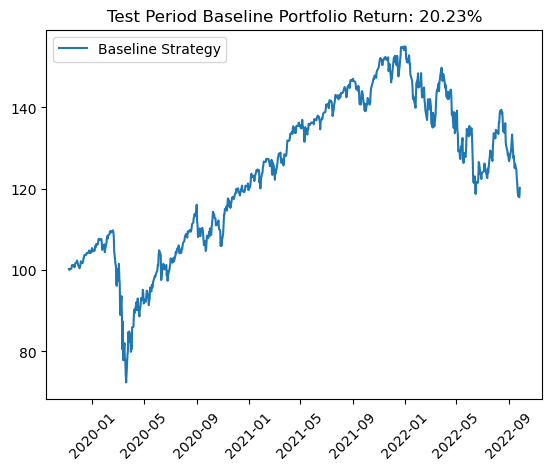

Numer of Days: 727
Percent Return: 20.23%
Precision Score: 0.547455295735901
Recall Score: 1.0
F1 Score: 0.7075555555555556


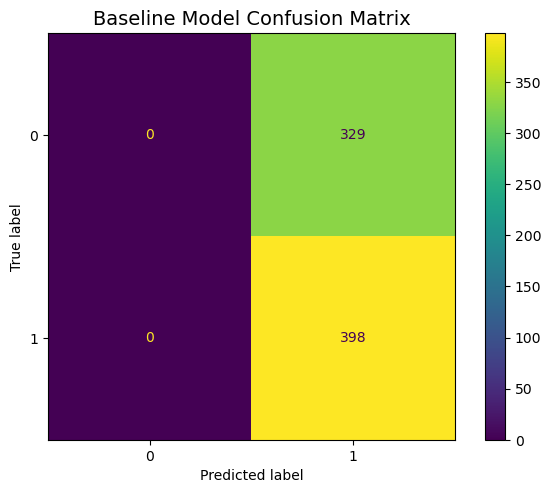

False Negative Rate: 0.0
False Positive Rate: 0.45


In [12]:
# Baseline Model:
num_pos = len(y[y == 1])
num_negative = len(y[y == 0])

if num_pos > num_negative:
    baseline_y_pred = np.array([1 for _ in range(len(y))])
else:
    baseline_y_pred = np.array([0 for _ in range(len(y))])

train_index = int(len(X) * 0.8)
val_index = int(len(X) * 0.9)

y_train = y[0:train_index]
y_val = y[train_index:val_index]
y_test = y[val_index:]

y_train_baseline_pred = baseline_y_pred[0:train_index]
y_val_baseline_pred = baseline_y_pred[train_index:val_index]
y_test_baseline_pred = baseline_y_pred[val_index:]

print("Baseline Train Accuracy:", accuracy_score(y_train, y_train_baseline_pred))
print("Baseline Val Accuracy:", accuracy_score(y_val, y_val_baseline_pred))
print("Baseline Test Accuracy:", accuracy_score(y_test, y_test_baseline_pred))

init_money = 100
print("Initial Value:", init_money)

y_percent_vals = spy_ohlc_df["Percent Next Day"].to_numpy()
y_percent_vals_test = y_percent_vals[val_index:]
old_money_vals = []
for val in y_percent_vals_test:
    init_money *= (1 + val)
    old_money_vals.append(init_money)
print("Ending Value:", init_money)

plt.plot(X_test_dates, old_money_vals, label="Baseline Strategy")
plt.legend()
plt.title("Test Period Baseline Portfolio Return: " + 
          str(percent_return1) + "%")
plt.xticks(rotation=45)
plt.show()

print("Numer of Days:", len(y_percent_vals_test))
percent_return1 = round((init_money - 100) / 100 * 100, 2)
print("Percent Return:", str(percent_return1) + "%")

# precision score:
print("Precision Score:", precision_score(y_test, y_test_baseline_pred))

# recall score:
print("Recall Score:", recall_score(y_test, y_test_baseline_pred))

# f1_score:
print("F1 Score:", f1_score(y_test, y_test_baseline_pred))

# confusion matrix:
cm = confusion_matrix(y_test, y_test_baseline_pred)
disp = ConfusionMatrixDisplay(cm,display_labels=['0', '1'])
disp.plot()
plt.tight_layout()
plt.title("Baseline Model Confusion Matrix", fontsize=14)
plt.show()


# FNR = FN / (FN+TP)
# of the positive values, what percent are predicted as negative 
# when they should be predicted as positive

# FPR = FP / (FP + TN)

# cm = [TN, FP,
#       FN, TP]
print("False Negative Rate:", round(cm[1][0] / (cm[1][0] + cm[1][1]), 2))
print("False Positive Rate:", round(cm[0][1] / (cm[0][1] + cm[1][1]), 2))  # 1 - precision

Val Test Size: 0.5
Logistic Regression:
Best Model Test Accuracy: 0.5543328748280605
Mean Test Score: 0.5416781292984869
Standard Deviation of Test Scores: 0.010931673445009926
NEGATIVE 10% DAY FOUND
2020-03-13 00:00:00
Ending Value: 167.02937587830831


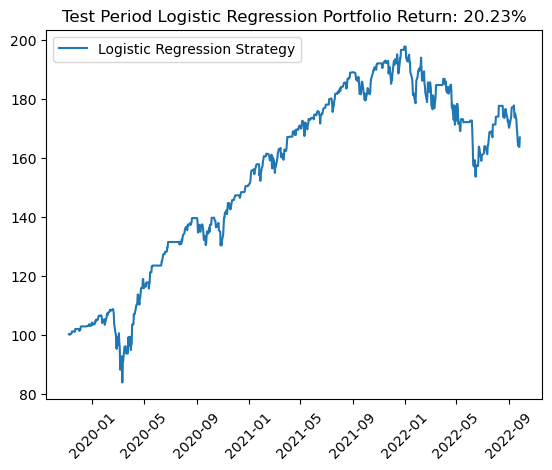

Numer of Days: 727
Percent Return: 67.03%
Precision Score: 0.5719844357976653
Recall Score: 0.7386934673366834
F1 Score: 0.6447368421052632


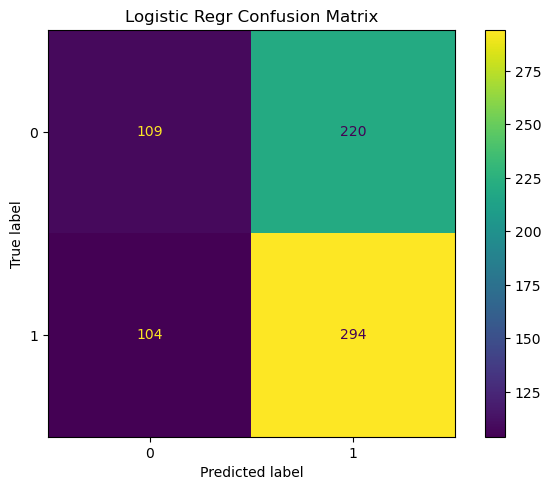

False Negative Rate: 0.26
False Positive Rate: 0.43


In [14]:
# Logstic Regression Model:
for val_size in [0.5]:
    print("Val Test Size:", val_size)
    # Logistic Regression
    print("Logistic Regression:")
    param_grid = { 'logisticregression__solver': ['lbfgs'],
                   'logisticregression__penalty' : ['l2'],
                   'logisticregression__C' : [0.01, 1, 10, 100, 1000] }
    clf = LogisticRegression(max_iter=5000)
    models, test_scores, test_preds, best_model, p_crit = \
        optimize_algorithm(X, y, preprocessor, clf, param_grid, val_size, num_rand_states=10)
    print("Mean Test Score:", np.mean(test_scores))
    print("Standard Deviation of Test Scores:", np.std(test_scores))

init_money = 100
y_percent_vals = spy_ohlc_df["Percent Next Day"].to_numpy()
y_percent_vals_test = y_percent_vals[val_index:]
old_money_vals = []
all_percents_recieved = []
all_neg_percents = []
all_pos_percents = []
pos_percents_gotten = []
neg_percents_gotten = []
pos_percents_missed = []
neg_percents_avoided = []
i = 0
for percent_return, dir_pred in zip(y_percent_vals_test, test_preds):
    if percent_return < -.1:
        print("NEGATIVE 10% DAY FOUND")
        print(X_test_dates[i])
    i += 1
    all_percents_recieved.append(percent_return)
    if percent_return > 0:
        all_pos_percents.append(percent_return)
    else:
        all_neg_percents.append(percent_return)
        
    if dir_pred == 1:
        if percent_return > 0:
            pos_percents_gotten.append(percent_return)
        else:
            neg_percents_gotten.append(percent_return)
        init_money *= (1 + percent_return)
    else:
        if percent_return > 0:
            pos_percents_missed.append(percent_return)
        else:
            neg_percents_avoided.append(percent_return)
    if init_money < 0:
        print("RAN OUT OF MONEY")
    old_money_vals.append(init_money)
print("Ending Value:", init_money)

plt.plot(X_test_dates, old_money_vals, label="Logistic Regression Strategy")
plt.legend()
plt.title("Test Period Logistic Regression Portfolio Return: " + 
          str(percent_return1) + "%")
plt.xticks(rotation=45)
plt.show()

print("Numer of Days:", len(y_percent_vals_test))
percent_return = round((init_money - 100) / 100 * 100, 2)
print("Percent Return:", str(percent_return) + "%")

# plt.plot(X_test_dates, old_money_vals, label="Portfolio Value")
# plt.legend()
# plt.title("Test Period Logistic Regression Portfolio Return: " + str(percent_return) + "%")
# plt.xticks(rotation=45)
# plt.show()

# histograms:
# all_pos_percents = [x*100 for x in all_pos_percents]
# plt.title("Full Distribution of Positive Percents in Test Set")
# plt.hist(all_pos_percents, bins=50)
# plt.xlabel("% Gain/Loss for Day")
# plt.ylabel("Count")
# plt.yticks([1, 5, 10, 20, 30, 40, 50, 60])
# plt.show()

# all_neg_percents = [x*100 for x in all_neg_percents]
# plt.title("Full Distribution of Negative Percents in Test Set")
# plt.hist(all_neg_percents, bins=50)
# plt.xlabel("% Gain/Loss for Day")
# plt.ylabel("Count")
# plt.yticks([1, 5, 10, 20, 30, 40, 50, 60])
# plt.show()


# pos_percents_gotten = [x*100 for x in pos_percents_gotten]
# plt.title("Distribution of Positive Percents Recieved from Logistic Regressin")
# plt.hist(pos_percents_gotten, bins=50)
# plt.xlabel("% Gain/Loss for Day")
# plt.ylabel("Count")
# plt.yticks([1, 5, 10, 20, 30, 40])
# plt.show()

# neg_percents_gotten = [x*100 for x in neg_percents_gotten]
# plt.title("Distribution of Negative Percents Recieved from Logistic Regression")
# plt.hist(neg_percents_gotten, bins=50)
# plt.xlabel("% Gain/Loss for Day")
# plt.ylabel("Count")
# plt.yticks([1, 5, 10, 20, 30, 40])
# plt.show()

# plt.title("Distribution of Positive Percents Missed")
# plt.hist(pos_percents_missed, bins=50)
# plt.show()

# plt.title("Distribution of Negative Percents Avoided")
# plt.hist(neg_percents_avoided, bins=50)
# plt.show()

# plt.title("All Percents Recieved")
# plt.hist(all_percents_recieved, bins=50)
# plt.show()

# plt.title("Overall Distribution of Returns")
# plt.hist(y_percent_vals_test, bins=50)
# plt.show()


# precision score:
print("Precision Score:", precision_score(y_test, test_preds))

# recall score:
print("Recall Score:", recall_score(y_test, test_preds))

# f1_score:
print("F1 Score:", f1_score(y_test, test_preds))
      
cm = confusion_matrix(y_test, test_preds)
disp = ConfusionMatrixDisplay(cm, display_labels=['0', '1'])
disp.plot()
plt.tight_layout()
plt.title("Logistic Regr Confusion Matrix")
plt.show()

# FNR = FN / (FN+TP)
# of the positive values, what percent are predicted as negative 
# when they should be predicted as positive

# FPR = FP / (FP + TN)

# cm = [TN, FP,
#       FN, TP]
print("False Negative Rate:", round(cm[1][0] / (cm[1][0] + cm[1][1]), 2))
print("False Positive Rate:", round(cm[0][1] / (cm[0][1] + cm[1][1]), 2))  # 1 - precision

Best Model Test Accuracy: 0.5543328748280605


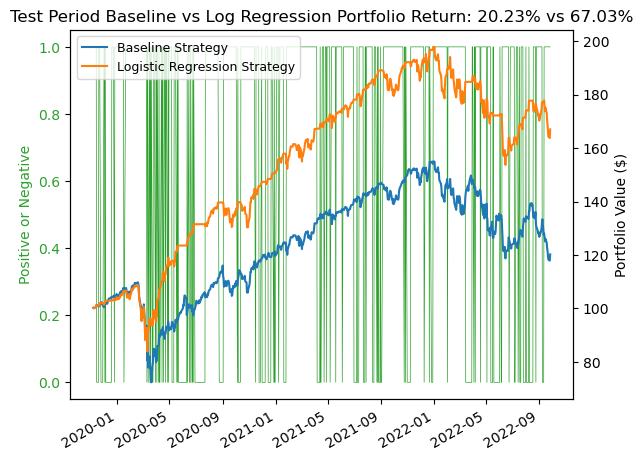

In [17]:
# Compare Baseline vs Logistic Regression:

init_money = 100

y_percent_vals = spy_ohlc_df["Percent Next Day"].to_numpy()
y_percent_vals_test = y_percent_vals[val_index:]
old_money_vals = []
for val in y_percent_vals_test:
    init_money *= (1 + val)
    old_money_vals.append(init_money)
    
percent_return1 = round((init_money - 100) / 100 * 100, 2)

# add logistic regression results to this graph. 
param_grid = { 'logisticregression__solver': ['lbfgs'],
                   'logisticregression__penalty' : ['l2'],
                   'logisticregression__C' : [0.01, 1, 10, 100, 1000] }
clf = LogisticRegression(max_iter=5000)
models, test_scores, test_preds, best_model, p_crit = \
    optimize_algorithm(X, y, preprocessor, clf, param_grid, 0.5, num_rand_states=10)
init_money = 100
y_percent_vals = spy_ohlc_df["Percent Next Day"].to_numpy()
y_percent_vals_test = y_percent_vals[val_index:]
old_money_vals2 = []

for percent_return, dir_pred in zip(y_percent_vals_test, test_preds):
    if dir_pred == 1:
        init_money *= (1 + percent_return)
    if init_money < 0:
        print("RAN OUT OF MONEY")
    old_money_vals2.append(init_money)
percent_return2 = round((init_money - 100) / 100 * 100, 2)

fig, ax2 = plt.subplots()

color = 'tab:green'
ax2.set_ylabel('Positive or Negative', color=color)  # we already handled the x-label with ax1
ax2.plot(X_test_dates, test_preds, color=color, linewidth=0.5)
ax2.tick_params(axis='y', labelcolor=color)

ax1 = ax2.twinx()  # instantiate a second axes that shares the same x-axis
ax1.set_xlabel('Date')
ax1.set_ylabel('Portfolio Value ($)')
ax1.plot(X_test_dates, old_money_vals, label="Baseline Strategy")
ax1.plot(X_test_dates, old_money_vals2, label="Logistic Regression Strategy")

ax1.tick_params(axis='y')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.legend(prop={'size': 9})
fig.autofmt_xdate()
plt.title("Test Period Baseline vs Log Regression Portfolio Return: " + 
          str(percent_return1) + "%" + " vs " + str(percent_return2) + "%")
plt.show()

In [18]:
def get_prof_score(test_preds):
    init_money = 100
    y_percent_vals = spy_ohlc_df["Percent Next Day"].to_numpy()
    y_percent_vals_test = y_percent_vals[val_index:]
    old_money_vals = []
    for percent_return, dir_pred in zip(y_percent_vals_test, test_preds):
        if dir_pred == 1:
            init_money *= (1 + percent_return)
        old_money_vals.append(init_money)
    percent_return = round((init_money - 100) / 100 * 100, 2)
    return percent_return

In [19]:
np.random.seed(7)

nr_runs = 10
feature_names = X_test.columns
scores = np.zeros([len(feature_names), nr_runs])
preds = best_model.predict_proba(X_test)
test_preds = np.where(preds[:, 1] > p_crit, 1, 0)
test_score = get_prof_score(test_preds)

for i in range(len(feature_names)):
    print('shuffling '+ str(feature_names[i]))
    acc_scores = []
    for j in range(nr_runs):
        X_test_shuffled = X_test.copy()
        X_test_shuffled[feature_names[i]] = np.random.permutation(X_test[feature_names[i]].values)
        preds = best_model.predict_proba(X_test_shuffled)
        shuffled_preds = np.where(preds[:, 1] > p_crit, 1, 0)
        acc_scores.append(get_prof_score(shuffled_preds))
        # acc_scores.append(accuracy_score(y_test, shuffled_preds))
    print('    shuffled test score:', np.around(np.mean(acc_scores),3),'+/-',np.around(np.std(acc_scores),3))
    scores[i] = acc_scores

shuffling Open
    shuffled test score: 63.148 +/- 8.189
shuffling High
    shuffled test score: 61.702 +/- 7.766
shuffling Low
    shuffled test score: 60.499 +/- 8.877
shuffling Close
    shuffled test score: 59.44 +/- 5.789
shuffling Volume
    shuffled test score: 69.309 +/- 1.892
shuffling Dates
    shuffled test score: 72.562 +/- 3.901
shuffling AwesomeIndicator
    shuffled test score: 68.59 +/- 1.56
shuffling KAMA
    shuffled test score: 60.857 +/- 8.573
shuffling PercentagePriceOscillator
    shuffled test score: 20.379 +/- 4.011
shuffling ROC
    shuffled test score: 51.745 +/- 18.468
shuffling RSI
    shuffled test score: 67.608 +/- 15.653
shuffling StochRSI
    shuffled test score: 49.02 +/- 12.55
shuffling StochasticOscillator
    shuffled test score: 49.007 +/- 9.817
shuffling TSI
    shuffled test score: 48.222 +/- 9.62
shuffling AccDistIndicator
    shuffled test score: 71.799 +/- 3.683
shuffling ChaikinMoneyFlow
    shuffled test score: 31.939 +/- 7.874
shuffling Ease

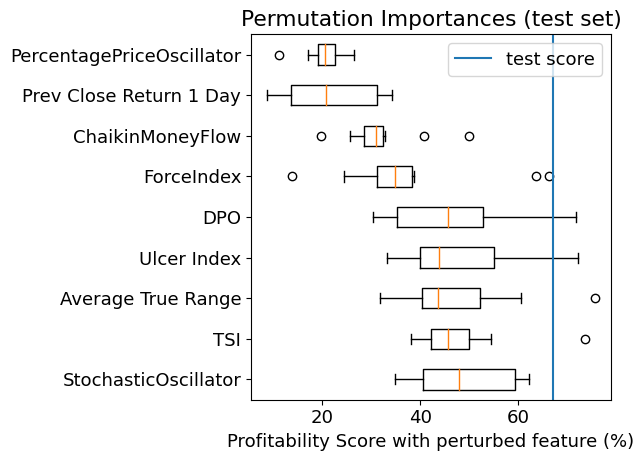

In [20]:
sorted_indcs = np.argsort(np.mean(scores,axis=1))[::-1]
plt.rcParams.update({'font.size': 13})
plt.figure(figsize=(6.4,4.8))
plt.boxplot(scores[sorted_indcs][-9:].T,labels=feature_names[sorted_indcs][-9:],vert=False)
plt.axvline(test_score,label='test score')
plt.title("Permutation Importances (test set)")
plt.xlabel('Profitability Score with perturbed feature (%)')
plt.legend()
plt.tight_layout()
plt.show()

Permutation explainer: 728it [00:19, 19.51it/s]                         


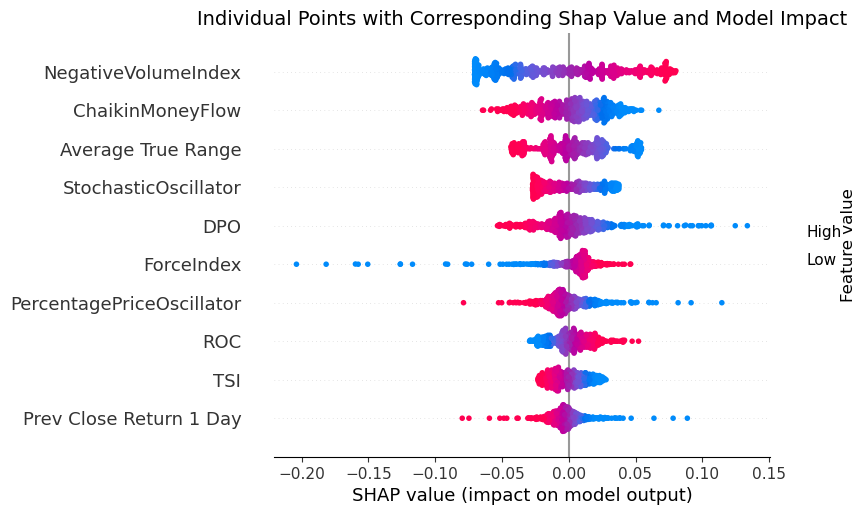

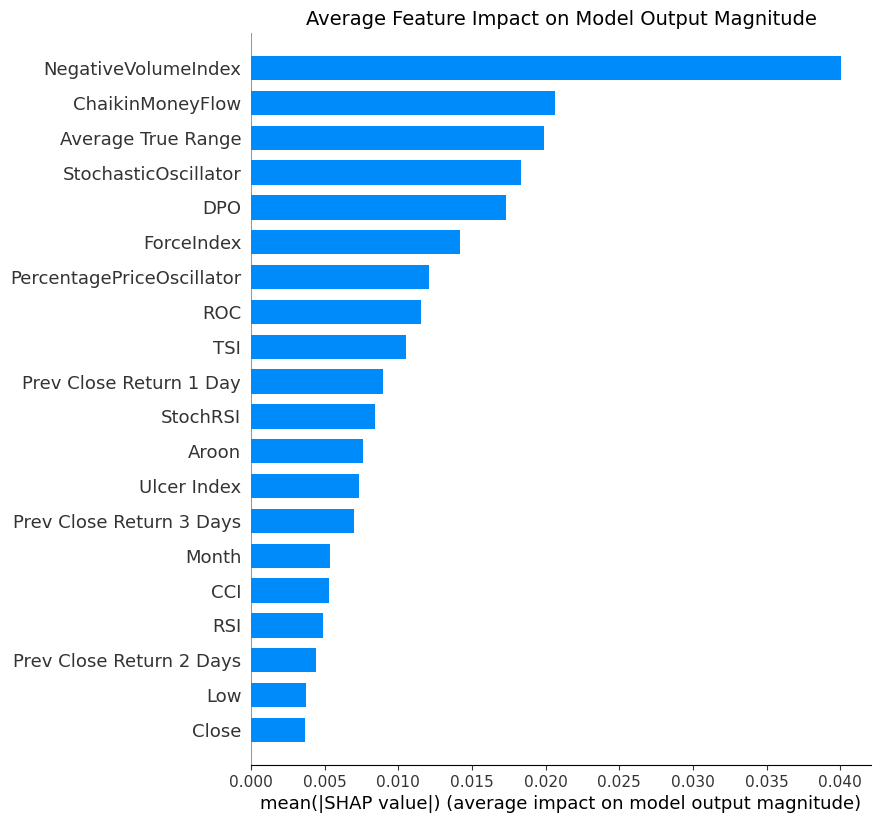

In [21]:
# Global SHAP:

def model_proba(x):
    return best_model.predict_proba(x)[:,1]

background_X_test = shap.maskers.Independent(X_test, max_samples=100)
explainer = shap.Explainer(model_proba, background_X_test)
shap_values = explainer(X_test[:1000])
plt.title("Individual Points with Corresponding Shap Value and Model Impact", fontsize=14)
shap.summary_plot(shap_values, X_test, max_display=10)

plt.title("Average Feature Impact on Model Output Magnitude", fontsize=14)
shap.summary_plot(shap_values, features=X_test, feature_names=X_test.columns, plot_type='bar')

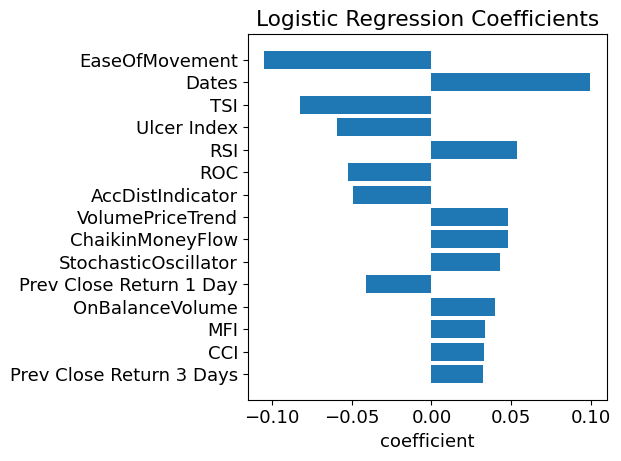

In [22]:
coefs = best_model.best_estimator_[-1].coef_[0]
sorted_indcs = np.argsort(np.abs(coefs))

plt.figure(figsize=(6.4,4.8))
plt.rcParams.update({'font.size': 13})
plt.barh(np.arange(15),coefs[sorted_indcs[-15:]])
plt.yticks(np.arange(15),feature_names[sorted_indcs[-15:]])
plt.xlabel('coefficient')
plt.title('Logistic Regression Coefficients')
plt.tight_layout()
plt.show()

# OTHER MODELS:

RandomForest Classifier:
Test Val Size: 0.5
Best Model Test Accuracy: 0.5488308115543329
Mean Test Score: 0.5177441540577716
Standard Deviation of Test Scores: 0.027614657697561728
Ending Value: 121.15901260783937
Numer of Days: 727
Percent Return: 21.16%


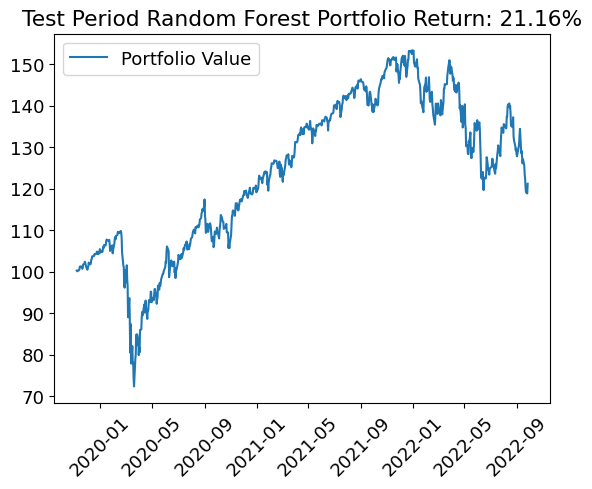

Precision Score: 0.5488826815642458
Recall Score: 0.9874371859296482
F1 Score: 0.7055655296229802


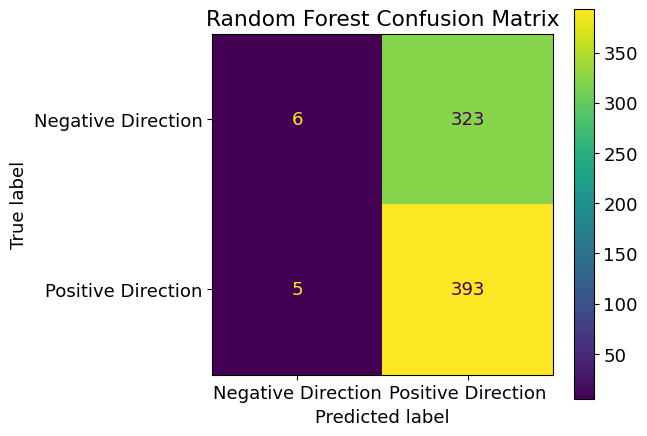

False Negative Rate: 0.01
False Positive Rate: 0.45


In [23]:
# RandomForest Classifier
for val_size in [0.5]:
    print("RandomForest Classifier:")
    print("Test Val Size:", val_size)
    param_grid2 = {
                  'randomforestclassifier__max_depth': [5, 10, 50, 100, None],
                   'randomforestclassifier__max_features': ['sqrt', 'log2'],
                  #'randomforestclassifier__max_features': [0.25, 0.5, 0.75, 1.0]
                  }
    clf2 = RandomForestClassifier()
    models2, test_scores2, test_preds, _, _ = optimize_algorithm(X, y, preprocessor, clf2, 
                                                param_grid2, val_size, num_rand_states=5)
    print("Mean Test Score:", np.mean(test_scores2))
    print("Standard Deviation of Test Scores:", np.std(test_scores2))
    
init_money = 100
y_percent_vals = spy_ohlc_df["Percent Next Day"].to_numpy()
y_percent_vals_test = y_percent_vals[val_index:]
old_money_vals = []
for percent_return, dir_pred in zip(y_percent_vals_test, test_preds):
    if dir_pred == 1:
        init_money *= (1 + percent_return)
    if init_money < 0:
        print("RAN OUT OF MONEY")
    old_money_vals.append(init_money)
print("Ending Value:", init_money)

print("Numer of Days:", len(y_percent_vals_test))
percent_return = round((init_money - 100) / 100 * 100, 2)
print("Percent Return:", str(percent_return) + "%")

plt.plot(X_test_dates, old_money_vals, label="Portfolio Value")
plt.legend()
plt.title("Test Period Random Forest Portfolio Return: " + str(percent_return) + "%")
plt.xticks(rotation=45)
plt.show()

# precision score:
print("Precision Score:", precision_score(y_test, test_preds))

# recall score:
print("Recall Score:", recall_score(y_test, test_preds))

# f1_score:
print("F1 Score:", f1_score(y_test, test_preds))

# confusion matrix:
cm = confusion_matrix(y_test, test_preds)
disp = ConfusionMatrixDisplay(cm,display_labels=['Negative Direction', 'Positive Direction'])
disp.plot()
plt.tight_layout()
plt.title("Random Forest Confusion Matrix")
plt.show()

# FNR = FN / (FN+TP)
# of the positive values, what percent are predicted as negative 
# when they should be predicted as positive

# FPR = FP / (FP + TN)

# cm = [TN, FP,
#       FN, TP]

print("False Negative Rate:", round(cm[1][0] / (cm[1][0] + cm[1][1]), 2))
print("False Positive Rate:", round(cm[0][1] / (cm[0][1] + cm[1][1]), 2))  # 1 - precision

Decision Tree Classifier:
Test Size 0.2
Best Model Test Accuracy: 0.5612104539202201
Mean Test Score: 0.5339752407152683
Standard Deviation of Test Scores: 0.0237355208914696
Ending Value: 139.9769626976045
Numer of Days: 727
Percent Return: 39.98%


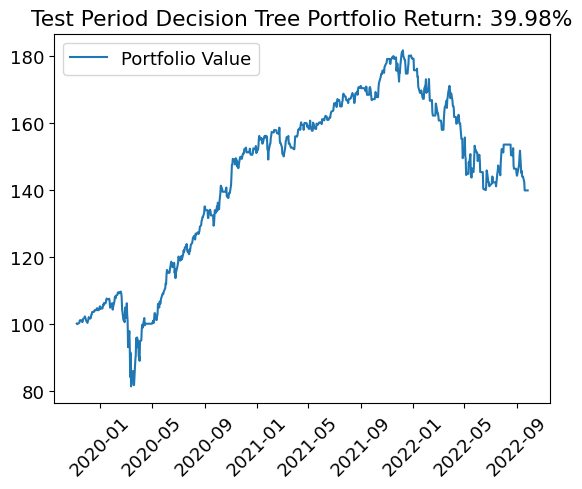

Precision Score: 0.5704099821746881
Recall Score: 0.8040201005025126
F1 Score: 0.667361835245047


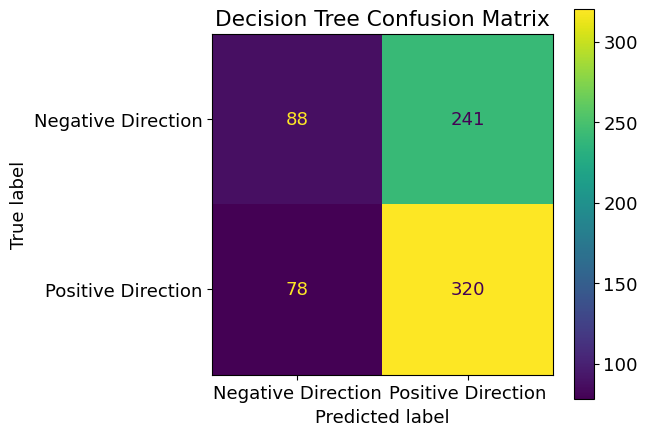

False Negative Rate: 0.2
False Positive Rate: 0.43


In [24]:
for val_size in [0.2]:
    print("Decision Tree Classifier:")
    print("Test Size", val_size)
    param_grid3 = { 
                    'decisiontreeclassifier__criterion': ['gini', 'entropy', 'log_loss'],
                     'decisiontreeclassifier__splitter': ['random', 'best'],
                    'decisiontreeclassifier__max_depth': [5, 8, 10, 25, 50, 75, 100, None],
                  }

    clf3 = DecisionTreeClassifier()
    models3, test_scores3, test_preds, _, _ = optimize_algorithm(X, y, preprocessor, clf3, param_grid3, 
                                                          val_size, num_rand_states=5)
    print("Mean Test Score:", np.mean(test_scores3))
    print("Standard Deviation of Test Scores:", np.std(test_scores3))
    
init_money = 100
y_percent_vals = spy_ohlc_df["Percent Next Day"].to_numpy()
y_percent_vals_test = y_percent_vals[val_index:]
old_money_vals = []
for percent_return, dir_pred in zip(y_percent_vals_test, test_preds):
    if dir_pred == 1:
        init_money *= (1 + percent_return)
    if init_money < 0:
        print("RAN OUT OF MONEY")
    old_money_vals.append(init_money)
print("Ending Value:", init_money)

print("Numer of Days:", len(y_percent_vals_test))
percent_return = round((init_money - 100) / 100 * 100, 2)
print("Percent Return:", str(percent_return) + "%")

plt.plot(X_test_dates, old_money_vals, label="Portfolio Value")
plt.legend()
plt.title("Test Period Decision Tree Portfolio Return: " + str(percent_return) + "%")
plt.xticks(rotation=45)
plt.show()

# precision score:
print("Precision Score:", precision_score(y_test, test_preds))

# recall score:
print("Recall Score:", recall_score(y_test, test_preds))

# f1_score:
print("F1 Score:", f1_score(y_test, test_preds))

# confusion matrix:
cm = confusion_matrix(y_test, test_preds)
disp = ConfusionMatrixDisplay(cm,display_labels=['Negative Direction', 'Positive Direction'])
disp.plot()
plt.tight_layout()
plt.title("Decision Tree Confusion Matrix")
plt.show()

# FNR = FN / (FN+TP)
# of the positive values, what percent are predicted as negative 
# when they should be predicted as positive

# FPR = FP / (FP + TN)

# cm = [TN, FP,
#       FN, TP]
print("False Negative Rate:", round(cm[1][0] / (cm[1][0] + cm[1][1]), 2))
print("False Positive Rate:", round(cm[0][1] / (cm[0][1] + cm[1][1]), 2))  # 1 - precision

SVC Classifier:
Test Size: 0.4
Best Model Test Accuracy: 0.547455295735901
Mean Test Score: 0.547455295735901
Standard Deviation of Test Scores: 0.0
Ending Value: 120.23168524411977
Numer of Days: 727
Percent Return: 20.23%


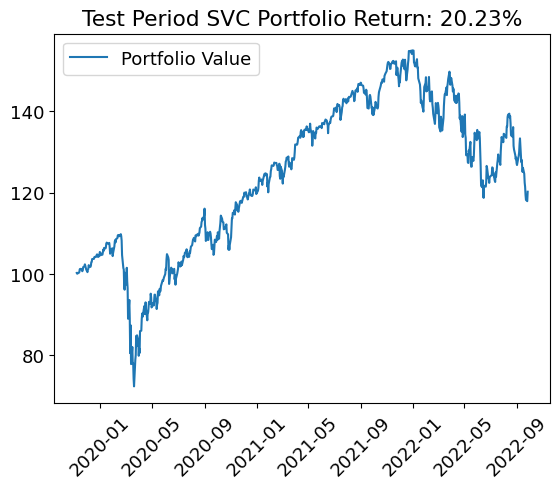

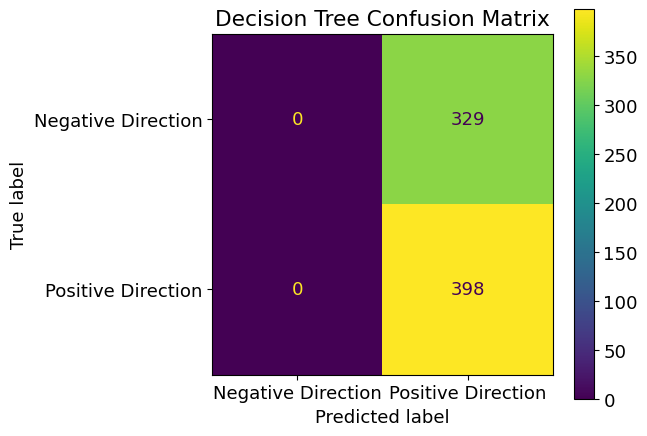

False Negative Rate: 0.0
False Positive Rate: 0.45


In [26]:
warnings.simplefilter(action='ignore', category=FutureWarning)
print("SVC Classifier:")
for val_size in [0.4]:
    print("Test Size:", val_size)
    param_grid5 = {"svc__C": [0.1, 1, 10, 100, 1000],
                   "svc__gamma": ["scale", "auto"]}

    clf5 = SVC(probability=True)
    models5, test_scores5, test_preds, _, _ = optimize_algorithm(X, y, preprocessor, clf5, param_grid5, 
                                                           val_size, num_rand_states=2)
    print("Mean Test Score:", np.mean(test_scores5))
    print("Standard Deviation of Test Scores:", np.std(test_scores5))
    
init_money = 100
y_percent_vals = spy_ohlc_df["Percent Next Day"].to_numpy()
y_percent_vals_test = y_percent_vals[val_index:]
old_money_vals = []
for percent_return, dir_pred in zip(y_percent_vals_test, test_preds):
    if dir_pred == 1:
        init_money *= (1 + percent_return)
    if init_money < 0:
        print("RAN OUT OF MONEY")
    old_money_vals.append(init_money)
print("Ending Value:", init_money)

print("Numer of Days:", len(y_percent_vals_test))
percent_return = round((init_money - 100) / 100 * 100, 2)
print("Percent Return:", str(percent_return) + "%")

plt.plot(X_test_dates, old_money_vals, label="Portfolio Value")
plt.legend()
plt.title("Test Period SVC Portfolio Return: " + str(percent_return) + "%")
plt.xticks(rotation=45)
plt.show()

# confusion matrix:
cm = confusion_matrix(y_test, test_preds)
disp = ConfusionMatrixDisplay(cm,display_labels=['Negative Direction', 'Positive Direction'])
disp.plot()
plt.tight_layout()
plt.title("Decision Tree Confusion Matrix")
plt.show()

# FNR = FN / (FN+TP)
# of the positive values, what percent are predicted as negative 
# when they should be predicted as positive

# FPR = FP / (FP + TN)

# cm = [TN, FP,
#       FN, TP]
print("False Negative Rate:", round(cm[1][0] / (cm[1][0] + cm[1][1]), 2))
print("False Positive Rate:", round(cm[0][1] / (cm[0][1] + cm[1][1]), 2))  # 1 - precision